In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import scipy.stats as stats
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')
sns.color_palette("Paired");
sns.set_theme();

# Data Loading

In [48]:
# setting path to results folder
root_path = '../../out/pretrained/adept/loci_looped/results'

# list all folders in root path that don't stat with a dot
nets = [f for f in os.listdir(root_path) if not f.startswith('.')]

# read pickle file
tf = pd.DataFrame()
sf = pd.DataFrame()
af = pd.DataFrame()

# load statistics files from nets
for net in nets:
    path = os.path.join(root_path, net, 'surprise', 'statistics',)
    with open(os.path.join(path, 'trialframe.csv'), 'rb') as f:
        tf_temp = pd.read_csv(f, index_col=0)
    tf_temp['net'] = net
    tf = pd.concat([tf,tf_temp])

    with open(os.path.join(path, 'slotframe.csv'), 'rb') as f:
        sf_temp = pd.read_csv(f, index_col=0)
    sf_temp['net'] = net
    sf = pd.concat([sf,sf_temp])

    with open(os.path.join(path, 'accframe.csv'), 'rb') as f:
        af_temp = pd.read_csv(f, index_col=0)
    af_temp['net'] = net
    af = pd.concat([af,af_temp])

# cast variables
sf['visible'] = sf['visible'].astype(bool)
sf['bound'] = sf['bound'].astype(bool)
sf['occluder'] = sf['occluder'].astype(bool)
sf['inimage'] = sf['inimage'].astype(bool)
sf['vanishing'] = sf['vanishing'].astype(bool)
sf['alpha_pos'] = 1-sf['alpha_pos']
sf['alpha_ges'] = 1-sf['alpha_ges']

# scale to percentage
sf['TE'] = sf['TE'] * 100

# add surprise as dummy code
tf['control'] = [('control' in set) for set in tf['set']]
sf['control'] = [('control' in set)  for set in sf['set']]

# Calculate Tracking Error (TE)

In [49]:
grouping = (sf.inimage & sf.bound & ~sf.occluder & sf.control)

def get_stats(col):
    return f' M: {col.mean():.3} , STD: {col.std():.3}, Count: {col.count()}'

# When Visible
temp = sf[grouping & sf.visible]
print(f'Tracking Error when visible:' + get_stats(temp['TE']))

# When Occluded
temp = sf[grouping & ~sf.visible]
print(f'Tracking Error when occluded:' + get_stats(temp['TE']))

Tracking Error when visible: M: 2.6 , STD: 2.79, Count: 5150
Tracking Error when occluded: M: 2.67 , STD: 1.85, Count: 1545


# Calculate Succesfull Trackings (TE)

In [50]:
# succesfull trackings: In the last visible moment of the target, the slot was less than 10% away from the target
# determine last visible frame numeric
grouping_factors = ['net','set','evalmode','scene','slot']
ff = sf[sf.visible & sf.bound & sf.inimage].groupby(grouping_factors).max()
ff.rename(columns = {'frame':'last_visible'}, inplace = True)
sf = sf.merge(ff[['last_visible']], on=grouping_factors, how='left')

# same for first bound frame
ff = sf[sf.visible & sf.bound & sf.inimage].groupby(grouping_factors).min()
ff.rename(columns = {'frame':'first_visible'}, inplace = True)
sf = sf.merge(ff[['first_visible']], on=grouping_factors, how='left')

# add dummy variable to sf
sf['last_visible'] = (sf['last_visible'] == sf['frame'])

# extract the trials where the target was last visible and threshold the TE
ff = sf[sf['last_visible']] 
ff['tracked_pos'] = (ff['TE'] < 10)
ff['tracked_neg'] = (ff['TE'] >= 10)

# fill NaN with 0
sf = sf.merge(ff[grouping_factors + ['tracked_pos', 'tracked_neg']], on=grouping_factors, how='left')
sf['tracked_pos'].fillna(False, inplace=True)
sf['tracked_neg'].fillna(False, inplace=True)

# Aggreagte over all scenes
temp = sf[(sf['frame']== 1) & ~sf.occluder & sf.control & (sf.first_visible < 20)]
temp = temp.groupby(['set', 'evalmode']).sum()
temp = temp[['tracked_pos', 'tracked_neg']]
temp = temp.reset_index()

temp['tracked_pos_pro'] = temp['tracked_pos'] / (temp['tracked_pos'] + temp['tracked_neg'])
temp['tracked_neg_pro'] = temp['tracked_neg'] / (temp['tracked_pos'] + temp['tracked_neg'])

temp

,set,evalmode,tracked_pos,tracked_neg,tracked_pos_pro,tracked_neg_pro
0,createdown_control,open,145,5,0.966667,0.033333


# Mostly Tracked stats

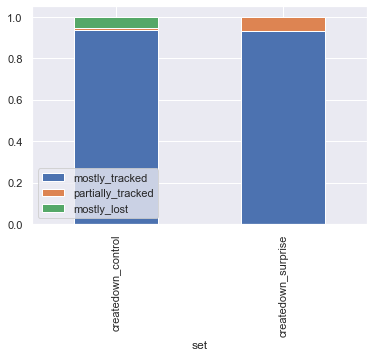

In [51]:
temp = af[af.index == 'OVERALL']
temp['mostly_tracked'] = temp['mostly_tracked'] / temp['num_unique_objects']
temp['partially_tracked'] = temp['partially_tracked'] / temp['num_unique_objects']
temp['mostly_lost'] = temp['mostly_lost'] / temp['num_unique_objects']
g = temp[['mostly_tracked', 'partially_tracked', 'mostly_lost','set']].set_index(['set']).groupby(['set']).mean().plot(kind='bar', stacked=True);

# MOTA 

In [52]:
af[af.index == 'OVERALL'].groupby(['set']).mean()

,idf1,idp,idr,recall,precision,num_unique_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,num_misses,num_switches,num_fragmentations,mota,motp,num_transfer,num_ascend,num_migrate
set,,,,,,,,,,,,,,,,,,
createdown_control,0.916600,0.904911,0.928800,0.936288,0.912202,86.0,80.333333,1.000000,4.666667,443.0,312.000000,10.666667,10.666667,0.843646,0.033253,1.333333,8.000000,0.0
createdown_surprise,0.860928,0.794099,0.942791,0.951446,0.801555,33.0,30.666667,2.333333,0.000000,381.0,76.666667,4.333333,9.000000,0.707410,0.032646,1.000000,2.666667,0.0


# Gate Openings

In [61]:
grouping = (sf.inimage & sf.bound & ~sf.occluder & sf.control)
temp = sf[grouping & sf.visible]
print(f'Percept gate openings when visible:' + get_stats(temp['alpha_pos'] + temp['alpha_ges']))
temp = sf[grouping & ~sf.visible]
print(f'Percept gate openings when occluded:' + get_stats(temp['alpha_pos'] + temp['alpha_ges']))

Percept gate openings when visible: M: 0.177 , STD: 0.235, Count: 5150
Percept gate openings when occluded: M: 0.0165 , STD: 0.0788, Count: 1545


# Correlations between visiblity mask of reappearing objects and visibility mask of vanishing objects

In [54]:
control_slot = sf[(sf['vanishing'] == False) &
                (sf['occluder'] == False) &
                sf['set'].isin(['createdown_control']) &
                #(sf['net'] == net) &
                (sf['tracked_pos']) &
                (sf['first_visible'] < 20)]
control_slot['visible'] = (control_slot['visible'] & control_slot['bound'])

vanish_slot = sf[(sf['vanishing'] == True) &
                (sf['occluder'] == False) &
                sf['set'].isin(['createdown_surprise']) &
                #(sf['net'] == net) & 
                (sf['tracked_pos']) & 
                (sf['first_visible'] < 20)]
vanish_slot['visible'] = (vanish_slot['visible'] & vanish_slot['bound'])

# correlation between slot error and control slot visibility
temp = vanish_slot.groupby(['frame']).mean().reset_index()
temp['visible'] = control_slot.groupby(['frame']).mean()['visible'].reset_index()['visible']

# correlation between slot error and control slot visibility
print(stats.pearsonr(temp['visible'][25:40], temp['slot_error'][25:40]))
print(stats.pearsonr(temp['visible'][25:40], temp['mask_size'][25:40]))

PearsonRResult(statistic=0.9090151765786597, pvalue=2.695881922780818e-06)
PearsonRResult(statistic=0.9416135178219641, pvalue=1.6338190527083593e-07)


# Plots VOE

In [55]:
def get_plot_complete():

    # line plot of mean slot error as a function of frames per jumping mode
    control_slot = sf[(sf['vanishing'] == False) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_control', 'createup_control']) &
                    #(sf['net'] == net) &
                    (sf['tracked_pos'])]
    control_slot['notvisible'] = ((control_slot['visible'] == False) | (control_slot['bound'] == False))
    control_label = 'Reappearing'

    # line plot of mean slot error as a function of frames per jumping mode
    vanish_slot = sf[(sf['vanishing'] == True) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_surprise', 'createup_control']) &
                    #(sf['net'] == net) & 
                    (sf['tracked_pos'])]
    vanish_label = 'Vanishing'

    a = control_slot.groupby(['frame']).mean()['notvisible'].to_list()

    # combined plot of slot error and tracking error
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 3, 3, 1]})
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    for i, (error,ylabel) in enumerate(zip(['slot_error', 'TE', 'rawmask_size', 'mask_size', 'alpha_pos', 'alpha_ges'],['Slot Error', 'Tracking Error', 'Object Mask Size', 'Visibility Mask Size', 'Position Updates', 'Gestalt Updates'])):

        # set row and column
        row = int(i/2)
        col = i % 2

        # line plot of slot error as a function of frames
        vslot = vanish_slot
        if error == 'TE':
            vslot = vanish_slot[(vanish_slot['TE'] > 0) | (vanish_slot['frame'] < 10)]
        sns.lineplot(x="frame", y=error, data=control_slot, ax=axs[row][col], label=control_label)
        sns.lineplot(x="frame", y=error, data=vslot, ax=axs[row][col], label=vanish_label)
        axs[row][col].set_xlabel('')
        axs[row][col].set_ylabel(ylabel)
        axs[row][col].legend()

        # add vertical line at 30 frames
        axs[row][col].axvline(x=28, color='green', linestyle='--', linewidth=0.5, alpha=0.5)

        if error == 'TE':
            axs[row][col].set_yticks([0, 1, 2, 3])
            axs[row][col].set_yticklabels(['0%', '1%', '2%', '3%'])

        # add a,b,c ... labels to the top left conrner of each plot
        axs[row][col].text(-0.2, 1, alphabet[i], transform=axs[row][col].transAxes, size=15, weight='bold')

    for col in [0,1]:

        # add occulusion plot
        axs[3][col].fill_between(range(len(a)),a,  color="green", alpha=0.2)
        axs[3][col].set_xlabel('Frame')
        axs[3][col].set_ylabel('Occlusion')

        # set y axis ticks as 0% to 100%
        axs[3][col].set_yticks([0, 1])
        #axs[3][col].set_yticks([])
        axs[3][col].set_yticklabels(['0%', '100%'])

        # add same text as above but center the text
        axs[3][col].text(28, 0.5, 'Object\nvanishes', fontsize=9, color='grey', rotation=90, ha='center', va='center')
        axs[3][col].text(60, 0.5, 'Occluder\nrotates', fontsize=9, color='grey', rotation=90, ha='center', va='center')

        # Update Gates
        axs[2][col].set_yticks([0, 0.2,0.4])
        axs[2][col].set_yticklabels(['0%', '20%', '40%'])
        axs[2][col].set_ylim(0, 0.4)

    plt.tight_layout()

    pass



def get_plot_voe():

    # line plot of mean slot error as a function of frames per jumping mode
    control_slot = sf[(sf['vanishing'] == False) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_control']) &
                    #(sf['net'] == net) &
                    (sf['tracked_pos']) &
                    (sf['first_visible'] < 20)]
    control_slot['visible'] = (control_slot['visible'] & control_slot['bound'])
    control_slot['slot_error'] = control_slot['slot_error'] * 10000000
    control_label = 'Reappearing'

    # line plot of mean slot error as a function of frames per jumping mode
    vanish_slot = sf[(sf['vanishing'] == True) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_surprise']) &
                    #(sf['net'] == net) & 
                    (sf['tracked_pos']) & 
                    (sf['first_visible'] < 20)]
    vanish_slot['visible'] = (vanish_slot['visible'] & vanish_slot['bound'])
    vanish_slot['slot_error'] = vanish_slot['slot_error'] * 10000000
    vanish_label = 'Vanishing'

    a = control_slot.groupby(['frame']).mean()['visible']
    b = vanish_slot.groupby(['frame']).mean()['visible']
    #b[28:] = 0

    # combined plot of slot error and tracking error
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    for i, (error,ylabel) in enumerate(zip(['slot_error', 'mask_size'],['Slot Error', 'Visibility Mask Size'])):

        # set row and column
        row = int(i/2) 
        col = i % 2

        # line plot of slot error as a function of frames
        vslot = vanish_slot
        if error == 'TE':
            vslot = vanish_slot[(vanish_slot['TE'] > 0) | (vanish_slot['frame'] < 10)]
        sns.lineplot(x="frame", y=error, data=control_slot, ax=axs[row][col], label=control_label)
        sns.lineplot(x="frame", y=error, data=vslot, ax=axs[row][col], label=vanish_label)
        axs[row][col].set_xlabel('')
        axs[row][col].set_ylabel(ylabel, fontsize=12)
        axs[row][col].legend()

        if error == 'TE':
            axs[row][col].set_yticks([0, 1, 2, 3])
            axs[row][col].set_yticklabels(['0%', '1%', '2%', '3%'])

        # add a,b,c ... labels to the top left conrner of each plot
        axs[row][col].text(-0.2, 1, alphabet[i], transform=axs[row][col].transAxes, size=15, weight='bold')

        # remove x axis ticks from top plot but keep grid lines in x axis
        if row == 0:
            axs[row][col].set_xticklabels([])
            axs[row][col].set_xlabel('')

    for col in [0,1]:

        # add occulusion plot
        axs[1][col].plot(range(len(a)),a.to_list(), label=control_label)
        axs[1][col].plot(range(len(a)),b.to_list(), label=vanish_label)
        axs[1][col].set_xlabel('Frame', fontsize=12)
        axs[1][col].set_ylabel('Visiblity', fontsize=12)

        # set y axis ticks as 0% to 100%
        axs[1][col].set_yticks([0, 1])
        #axs[3][col].set_yticks([])
        axs[1][col].set_yticklabels(['0%', '100%'])

        # add same text as above but center the text
        axs[1][col].text(28, 0.5, 'Object\nvanishes', fontsize=9, color='grey', rotation=90, ha='center', va='center')
        axs[1][col].text(60, 0.5, 'Occluder\nrotates', fontsize=9, color='grey', rotation=90, ha='center', va='center')

        # Update Gates
        #axs[2][col].set_yticks([0, 0.2,0.4])
        #axs[2][col].set_yticklabels(['0%', '20%', '40%'])
        #axs[2][col].set_ylim(0, 0.4)


    # add arrow to plot axs[0][0] at position (x,y) = (10, 0.5)
    axs[0][0].annotate('', xy=(33, 0.45), xytext=(25, 0.6), arrowprops={'arrowstyle': '->', 'color': 'black'})
    axs[0][0].text(21, 0.62, 'Expectation', fontsize=9, color='black', ha='center', va='center')

    axs[0][0].annotate('', xy=(63, 0.31), xytext=(56, 0.45), arrowprops={'arrowstyle': '->', 'color': 'black'})
    axs[0][0].text(52, 0.47, 'Expectation', fontsize=9, color='black', ha='center', va='center')

    plt.tight_layout()

    pass

def get_plot_gates():

    # line plot of mean slot error as a function of frames per jumping mode
    control_slot = sf[(sf['vanishing'] == False) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_control']) &
                    #(sf['net'] == net) &
                    (sf['tracked_pos']) &
                    (sf['first_visible'] < 20)]
    control_slot['visible'] = (control_slot['visible'] & control_slot['bound'])
    control_slot['slot_error'] = control_slot['slot_error'] * 10000000
    control_label = 'Reappearing'

    # line plot of mean slot error as a function of frames per jumping mode
    vanish_slot = sf[(sf['vanishing'] == True) &
                    (sf['occluder'] == False) &
                    sf['set'].isin(['createdown_surprise']) &
                    #(sf['net'] == net) & 
                    (sf['tracked_pos']) & 
                    (sf['first_visible'] < 20)]
    vanish_slot['visible'] = (vanish_slot['visible'] & vanish_slot['bound'])
    vanish_slot['slot_error'] = vanish_slot['slot_error'] * 10000000
    vanish_label = 'Vanishing'

    a = control_slot.groupby(['frame']).mean()['visible']
    b = vanish_slot.groupby(['frame']).mean()['visible']
    #b[28:] = 0

    # combined plot of slot error and tracking error
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    for i, (error,ylabel) in enumerate(zip(['alpha_pos', 'alpha_ges'],['Position Updates', 'Gestalt Updates'])):

        # set row and column
        row = int(i/2) 
        col = i % 2

        # line plot of slot error as a function of frames
        vslot = vanish_slot
        if error == 'TE':
            vslot = vanish_slot[(vanish_slot['TE'] > 0) | (vanish_slot['frame'] < 10)]
        sns.lineplot(x="frame", y=error, data=control_slot, ax=axs[row][col], label=control_label)
        sns.lineplot(x="frame", y=error, data=vslot, ax=axs[row][col], label=vanish_label)
        axs[row][col].set_xlabel('')
        axs[row][col].set_ylabel(ylabel, fontsize=12)
        axs[row][col].legend()

        # set y lim from 0 to 0.6
        axs[row][col].set_ylim(0, 0.6)

        axs[row][col].set_yticks([0, 0.3, 0.6])
        axs[row][col].set_yticklabels(['0%', '30%', '60%'])

        # add a,b,c ... labels to the top left conrner of each plot
        axs[row][col].text(-0.2, 1, alphabet[i], transform=axs[row][col].transAxes, size=15, weight='bold')

        # remove x axis ticks from top plot but keep grid lines in x axis
        if row == 0:
            axs[row][col].set_xticklabels([])
            axs[row][col].set_xlabel('')

    for col in [0,1]:

        # add occulusion plot
        axs[1][col].plot(range(len(a)),a.to_list(), label=control_label)
        axs[1][col].plot(range(len(a)),b.to_list(), label=vanish_label)
        axs[1][col].set_xlabel('Frame', fontsize=12)
        axs[1][col].set_ylabel('Visiblity', fontsize=12)

        # set y axis ticks as 0% to 100%
        axs[1][col].set_yticks([0, 1])
        #axs[3][col].set_yticks([])
        axs[1][col].set_yticklabels(['0%', '100%'])

        # add same text as above but center the text
        axs[1][col].text(28, 0.5, 'Object\nvanishes', fontsize=9, color='grey', rotation=90, ha='center', va='center')
        axs[1][col].text(60, 0.5, 'Occluder\nrotates', fontsize=9, color='grey', rotation=90, ha='center', va='center')

        # Update Gates
        #axs[2][col].set_yticks([0, 0.2,0.4])
        #axs[2][col].set_yticklabels(['0%', '20%', '40%'])
        #axs[2][col].set_ylim(0, 0.4)


    plt.tight_layout()

    pass

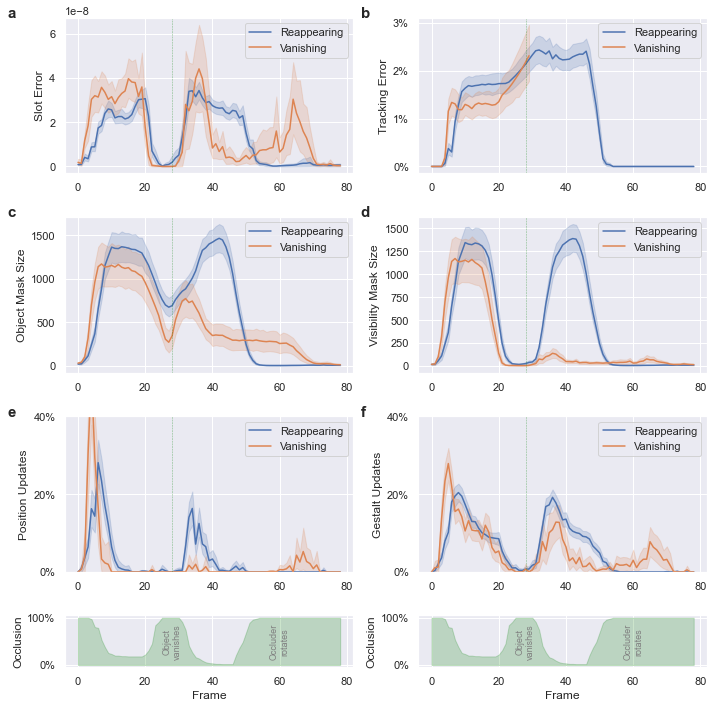

In [56]:
get_plot_complete()
plt.savefig('plots/loci_looped_complete.pdf')

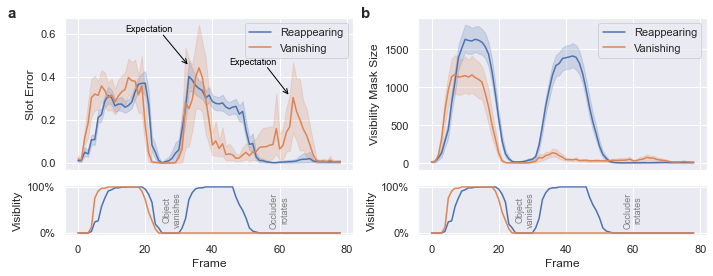

In [57]:
get_plot_voe()
plt.savefig('plots/loci_looped_voe.pdf')

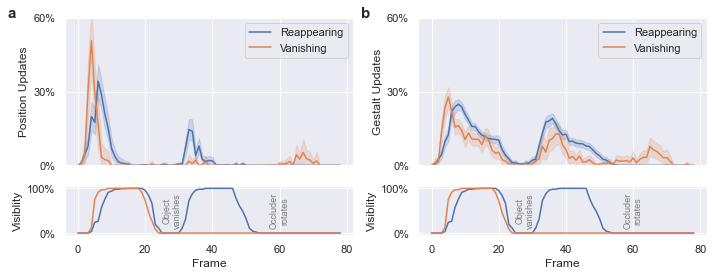

In [58]:
get_plot_gates()
plt.savefig('plots/loci_looped_gates.pdf')